# Does Picking a First-Round Quarterback Improve Team Success?
#### A 20-Year Analysis of First-Round QB Picks and NFL Team Performance

NFL teams invest heavily in quarterbacks and often use top draft picks in hopes of finding a franchise cornerstone. **But does drafting a quarterback in the first round actually lead to more team success?**

This analysis will explore how selecting a QB in the first round impacts a team’s win totals in the short term (1 year), medium term (2–3 years), and long term (5 years). I'll also explore whether using a top-10 pick makes a measurable difference.

## 1. Setup and Imports

Start by importing the Python libraries needed. You may need to run the command below to ensure they are all installed.

In [ ]:
%pip install -q pandas scipy statsmodel matplotlib seaborn nfl_data_py

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

# show all columns in Pandas outputs
pd.set_option('display.max_columns', None)

## 2. Load and Filter Draft Picks

I'll use `nfl_data_py` to pull all NFL draft picks from 2000 onward and filter to quarterbacks selected in the first round (picks 1–32). Let's also flag whether each QB was picked in the top 10.

In [3]:
import nfl_data_py as nfl

# Load all draft picks from 2000 to most recent season
draft_df = nfl.import_draft_picks(years=list(range(2000, 2024)))

# Filter for first-round QBs
qb_drafts = draft_df[(draft_df["position"] == "QB") & (draft_df["pick"] <= 32)].copy()

# Add flag for top-10 picks
qb_drafts["top_10"] = qb_drafts["pick"] <= 10

# Select relevant columns
qb_drafts = qb_drafts[[
    "season", "team", "pfr_player_name", "pick", "position", "top_10"
]].rename(columns={
    "season": "draft_year",
    "team": "team_abbr",
    "pfr_player_name": "qb_name",
    "pick": "pick_overall"
})

qb_drafts.reset_index(drop=True, inplace=True)
qb_drafts.to_csv("../data/qb_drafted_first_round.csv", index=False)

# Preview
qb_drafts.head()

,draft_year,team_abbr,qb_name,pick_overall,position,top_10
0,2000,NYJ,Chad Pennington,18,QB,False
1,2001,ATL,Michael Vick,1,QB,True
2,2001,SDG,Drew Brees,32,QB,False
3,2002,HOU,David Carr,1,QB,True
4,2002,DET,Joey Harrington,3,QB,True


## 3. Preparing Draft and Team Win Data

Unfortunately, `nfl_data_py` does not support team record logs in a reliable format (I tried `nfl.import_win_totals(years)` only to learn those were projected win totals for betting 😞, but maybe that fits your usecase! [Link](https://pypi.org/project/nfl-data-py/#description) )

Instead, I can use `nfl.import_schedules()` to access every regular season game and determine the winner based on score. By grouping home and away wins, I'll compute team win totals per year.

### 3a. Calculating Team Wins from Official Schedule Results

In [4]:
# Pull game schedules from 1999–2023
schedules = nfl.import_schedules(years=list(range(1999, 2024)))

# Keep only regular season games
schedules = schedules[schedules["game_type"] == "REG"]

# Create full team-year grid from both home and away teams
team_years = pd.concat([
    schedules[["season", "home_team"]].rename(columns={"season": "year", "home_team": "team_abbr"}),
    schedules[["season", "away_team"]].rename(columns={"season": "year", "away_team": "team_abbr"})
])
team_years = team_years.drop_duplicates().sort_values(["year", "team_abbr"]).reset_index(drop=True)

# Count wins: home team wins when home_score > away_score
home_wins = schedules[schedules["home_score"] > schedules["away_score"]]
home_wins = home_wins.groupby(["season", "home_team"]).size().reset_index(name="wins")
home_wins.rename(columns={"season": "year", "home_team": "team_abbr"}, inplace=True)

# Count wins: away team wins when away_score > home_score
away_wins = schedules[schedules["away_score"] > schedules["home_score"]]
away_wins = away_wins.groupby(["season", "away_team"]).size().reset_index(name="wins")
away_wins.rename(columns={"season": "year", "away_team": "team_abbr"}, inplace=True)

# Combine all wins
wins_combined = pd.concat([home_wins, away_wins])
team_wins = wins_combined.groupby(["year", "team_abbr"])["wins"].sum().reset_index()

# Merge with full team-year grid to preserve 0-win seasons
team_wins_full = team_years.merge(team_wins, on=["year", "team_abbr"], how="left")
team_wins_full["wins"] = team_wins_full["wins"].fillna(0).astype(int)

# Save for future use
team_wins_full.to_csv("../data/team_wins_by_year.csv", index=False)

# Preview
pd.concat([team_wins_full.head(), team_wins_full.tail()])

,year,team_abbr,wins
0,1999,ARI,6
1,1999,ATL,5
2,1999,BAL,8
3,1999,BUF,11
4,1999,CAR,8
792,2023,SEA,9
793,2023,SF,12
794,2023,TB,9
795,2023,TEN,6
796,2023,WAS,4


### 3a. Normalizing Team Abbreviations Before Merging

NFL teams have changed names and locations over time (San Diego Chargers to Los Angeles Chargers, for example). I'll preserve original abbreviations for display but create normalized ones for merging.

In [5]:
# Save original draft team abbreviation for reference
qb_drafts["team_abbr_orig"] = qb_drafts["team_abbr"]

# Create normalized version for merging
team_abbr_fix = {
    "SDG": "LAC",  # Chargers
    "OAK": "LV",   # Raiders
    "STL": "LAR",  # Rams
    "RAI": "LV",   # Legacy Raiders (some older data)
    "JAC": "JAX",  # Standardize Jacksonville
}

qb_drafts["team_abbr_merged"] = qb_drafts["team_abbr"].replace(team_abbr_fix)
team_wins["team_abbr_merged"] = team_wins["team_abbr"].replace(team_abbr_fix)

### 3b. Rolling 3-Year Average for Team Baseline
Next, I calculate a rolling 3-year average of team wins (excluding the draft year) to capture long-term trends in team performance. This will help identify if a QB was drafted during a prolonged slump (or a poorly run organization) not just a single bad year.

In [6]:
# Sort full team win records (including 0s) for rolling average calculation
team_wins_sorted = team_wins.sort_values(by=["team_abbr_merged", "year"])

# Calculate 3-year rolling average of wins, excluding draft year by shifting back 1 year
team_wins_sorted["wins_before_3yr_avg"] = (
    team_wins_sorted
    .groupby("team_abbr_merged")["wins"]
    .shift(1)  # shift by 1 to exclude current (draft) year
    .rolling(window=3, min_periods=2)
    .mean()
    .reset_index(drop=True)
)

# Preview rolling average for last few rows
team_wins_sorted[["team_abbr_merged", "year", "wins", "wins_before_3yr_avg"]].tail()

,team_abbr_merged,year,wins,wins_before_3yr_avg
666,WAS,2019,3,8.000000
698,WAS,2020,7,7.333333
730,WAS,2021,7,7.333333
762,WAS,2022,8,4.000000
794,WAS,2023,4,7.333333


### 3c. Defining Which Years to Merge
To measure draft impact, I want to compare future win outcomes relative to the draft year: before, 1 year after, 2–3 avg, and 5 years later.

In [7]:
# Define offset years for win comparison (relative to QB draft year)
qb_drafts["year_before"] = qb_drafts["draft_year"] - 1
qb_drafts["year_after_1"] = qb_drafts["draft_year"] + 1
qb_drafts["year_after_2"] = qb_drafts["draft_year"] + 2
qb_drafts["year_after_3"] = qb_drafts["draft_year"] + 3
qb_drafts["year_after_5"] = qb_drafts["draft_year"] + 5

# Preview a few rows to confirm correct offsets
qb_drafts[["draft_year", "qb_name", "year_before", "year_after_1", "year_after_5"]].head()

,draft_year,qb_name,year_before,year_after_1,year_after_5
0,2000,Chad Pennington,1999,2001,2005
1,2001,Michael Vick,2000,2002,2006
2,2001,Drew Brees,2000,2002,2006
3,2002,David Carr,2001,2003,2007
4,2002,Joey Harrington,2001,2003,2007


### 3d. Merge in Win Outcomes by Year
I can now merge our draft data with team win outcomes for:
- One year before the draft
- Three seasons before the draft (averaged)
- One year after
- Two and three years after (averaged)
- Five years after (end of rookie contract + extension)

In [8]:
# Use the full corrected team wins dataset (including 0-win years)
team_wins_full = pd.read_csv("../data/team_wins_by_year.csv")

# Ensure abbreviation merge consistency
team_wins_full["team_abbr_merged"] = team_wins_full["team_abbr"].replace(team_abbr_fix)

# Merge year before wins
qb_drafts = qb_drafts.merge(
    team_wins_full[["team_abbr_merged", "year", "wins"]],
    left_on=["team_abbr_merged", "year_before"],
    right_on=["team_abbr_merged", "year"],
    how="left"
).rename(columns={"wins": "wins_before"}).drop(columns="year")

# Merge rolling 3-year average
team_wins_sorted = team_wins_full.sort_values(by=["team_abbr_merged", "year"])
team_wins_sorted["wins_before_3yr_avg"] = (
    team_wins_sorted
    .groupby("team_abbr_merged")["wins"]
    .shift(1)
    .rolling(window=3, min_periods=2)
    .mean()
    .reset_index(drop=True)
)

qb_drafts = qb_drafts.merge(
    team_wins_sorted[["team_abbr_merged", "year", "wins_before_3yr_avg"]],
    left_on=["team_abbr_merged", "year_before"],
    right_on=["team_abbr_merged", "year"],
    how="left"
).drop(columns="year")

# Merge year after 1
qb_drafts = qb_drafts.merge(
    team_wins_full[["team_abbr_merged", "year", "wins"]],
    left_on=["team_abbr_merged", "year_after_1"],
    right_on=["team_abbr_merged", "year"],
    how="left"
).rename(columns={"wins": "wins_after_1"}).drop(columns="year")

# Merge years 2 and 3 separately, then average
wins_2 = team_wins_full.rename(columns={"year": "year_after_2", "wins": "wins_after_2"})
wins_3 = team_wins_full.rename(columns={"year": "year_after_3", "wins": "wins_after_3"})

qb_drafts = qb_drafts.merge(
    wins_2[["team_abbr_merged", "year_after_2", "wins_after_2"]],
    on=["team_abbr_merged", "year_after_2"], how="left"
)
qb_drafts = qb_drafts.merge(
    wins_3[["team_abbr_merged", "year_after_3", "wins_after_3"]],
    on=["team_abbr_merged", "year_after_3"], how="left"
)
qb_drafts["wins_after_2_3"] = qb_drafts[["wins_after_2", "wins_after_3"]].mean(axis=1)
qb_drafts.drop(columns=["wins_after_2", "wins_after_3"], inplace=True)

# Merge year 5
qb_drafts = qb_drafts.merge(
    team_wins_full[["team_abbr_merged", "year", "wins"]],
    left_on=["team_abbr_merged", "year_after_5"],
    right_on=["team_abbr_merged", "year"],
    how="left"
).rename(columns={"wins": "wins_after_5"}).drop(columns="year")

# Preview win deltas
qb_drafts[[
    "qb_name", "draft_year", "wins_before", "wins_before_3yr_avg",
    "wins_after_1", "wins_after_2_3", "wins_after_5"
]].head()

,qb_name,draft_year,wins_before,wins_before_3yr_avg,wins_after_1,wins_after_2_3,wins_after_5
0,Chad Pennington,2000,8.0,6.000000,10.0,7.5,4.0
1,Michael Vick,2001,4.0,8.000000,9.0,8.0,7.0
2,Drew Brees,2001,NaN,NaN,NaN,NaN,NaN
3,David Carr,2002,NaN,NaN,5.0,4.5,8.0
4,Joey Harrington,2002,2.0,11.666667,5.0,5.5,7.0


### 3e. Missing Values and Edge Cases

Some rows have missing data (`NaN`) for win totals for a few reasons:

- Expansion teams like the Houston Texans don’t have historical data for "wins_before" or "wins_before_3yr_avg". This is expected since the teams didn't exist.
- Some quarterbacks (Drew Brees) were either traded shortly after the draft or did not start for the team that drafted them. Since my merge keys are based on draft team and year, these players may show as `NaN` post-draft.

I need to identify/flag these scenarios then filter for clean data to form my final dataset.

In [9]:
# Flag missing 3-year win average (expansion teams, early years)
qb_drafts["missing_3yr_avg"] = qb_drafts["wins_before_3yr_avg"].isna()

# Flag if there's no post-draft win data (can't measure impact at all)
qb_drafts["incomplete_post_win_data"] = qb_drafts[["wins_after_1", "wins_after_2_3", "wins_after_5"]].isna().all(axis=1)

### 3f. Check if QBs Played for Drafting Team in Year 1
I'll use weekly stats to check if a QB logged snaps in their rookie year for the team that drafted them.

In [10]:
from nfl_data_py import import_weekly_data

# Get valid draft years for rookie seasons
valid_years = qb_drafts["year_after_1"].dropna().astype(int).unique().tolist()

# Pull all weekly QB data for those years
weekly_year1 = import_weekly_data(years=valid_years)
weekly_qbs = weekly_year1[weekly_year1["position"] == "QB"]

# Count games played per QB/team in their rookie year
qb_year1_appearances = (
    weekly_qbs.groupby(["season", "player_display_name", "recent_team"])
    .size()
    .reset_index(name="games_played")
    .rename(columns={
        "season": "year_after_1",
        "recent_team": "team_abbr",
        "player_display_name": "qb_name"
    })
)

# Merge with our draft dataset
qb_drafts = qb_drafts.merge(
    qb_year1_appearances[["year_after_1", "qb_name", "team_abbr"]].assign(played_for_team=True),
    left_on=["year_after_1", "qb_name", "team_abbr"],
    right_on=["year_after_1", "qb_name", "team_abbr"],
    how="left"
)

# Flag if QB was traded/benched (didn't play for their drafting team in year 1)
qb_drafts["traded_or_did_not_play_year1"] = qb_drafts["played_for_team"].isna()
qb_drafts.drop(columns=["played_for_team"], inplace=True)

Downcasting floats.


I'll print a flag summar, then keep only rows where I can meaningfully assess the QB's impact.

In [11]:
# Review how many rows fall under each category
flag_summary = qb_drafts[[
    "missing_3yr_avg",
    "incomplete_post_win_data",
    "traded_or_did_not_play_year1"
]].sum()

print("Flag summary:\n", flag_summary)

# Final cleaned dataset: keep QBs with post-draft data who played for draft team
qb_drafts_cleaned = qb_drafts[
    (~qb_drafts["missing_3yr_avg"]) &
    (~qb_drafts["incomplete_post_win_data"]) &
    (~qb_drafts["traded_or_did_not_play_year1"])
].copy()


columns_to_keep = [
    "draft_year",
    "team_abbr",
    "qb_name",
    "pick_overall",
    "top_10",
    "wins_before",
    "wins_before_3yr_avg",
    "wins_after_1",
    "wins_after_2_3",
    "wins_after_5"
]
qb_drafts_cleaned = qb_drafts_cleaned[columns_to_keep]
qb_drafts_cleaned.to_csv("../data/qb_drafted_first_round_cleaned.csv", index=False)

# Preview final
qb_drafts_cleaned.head(10)

Flag summary:
 missing_3yr_avg                 11
incomplete_post_win_data        14
traded_or_did_not_play_year1    18
dtype: int64


,draft_year,team_abbr,qb_name,pick_overall,top_10,wins_before,wins_before_3yr_avg,wins_after_1,wins_after_2_3,wins_after_5
0,2000,NYJ,Chad Pennington,18,False,8.0,6.000000,10.0,7.5,4.0
4,2002,DET,Joey Harrington,3,True,2.0,11.666667,5.0,5.5,7.0
5,2002,WAS,Patrick Ramsey,32,False,8.0,7.666667,5.0,8.0,9.0
6,2003,CIN,Carson Palmer,1,True,2.0,12.333333,8.0,9.5,4.0
7,2003,JAX,Byron Leftwich,7,True,6.0,9.666667,9.0,10.0,5.0
8,2003,BAL,Kyle Boller,19,False,7.0,7.333333,9.0,9.5,11.0
9,2003,CHI,Rex Grossman,22,False,4.0,11.333333,5.0,12.0,9.0
12,2004,PIT,Ben Roethlisberger,11,False,6.0,5.666667,11.0,9.0,9.0
13,2004,BUF,J.P. Losman,22,False,6.0,8.000000,5.0,7.0,6.0
16,2005,WAS,Jason Campbell,25,False,6.0,4.666667,5.0,8.5,6.0


### **Excluded Quarterbacks**

To explicitly note, I've excluded quarterbacks who either:

- Did not have enough follow-up win data to evaluate impact (recent picks)
- Did not play for their drafting team in their first year (likely traded, injured, or benched)
- Were drafted by an expansion team with no historical data

Below is the table of quarterbacks who were excluded from the cleaned dataset.

In [12]:
# Extract and preview excluded quarterbacks
excluded_qbs = qb_drafts[
    (qb_drafts["missing_3yr_avg"]) |
    (qb_drafts["incomplete_post_win_data"]) |
    (qb_drafts["traded_or_did_not_play_year1"])
][[
    "draft_year", "team_abbr_orig", "qb_name", "pick_overall", "top_10",
    "wins_before", "wins_before_3yr_avg", "wins_after_1", "wins_after_2_3", "wins_after_5",
    "missing_3yr_avg", "incomplete_post_win_data", "traded_or_did_not_play_year1"
]]

excluded_qbs.to_csv("../data/excluded_qbs.csv", index=False)

# Show full table of excluded QBs
excluded_qbs.reset_index(drop=True)

,draft_year,team_abbr_orig,qb_name,pick_overall,top_10,wins_before,wins_before_3yr_avg,wins_after_1,wins_after_2_3,wins_after_5,missing_3yr_avg,incomplete_post_win_data,traded_or_did_not_play_year1
0,2001,ATL,Michael Vick,1,True,4.0,8.000000,9.0,8.0,7.0,False,False,True
1,2001,SDG,Drew Brees,32,False,NaN,NaN,NaN,NaN,NaN,True,True,True
2,2002,HOU,David Carr,1,True,NaN,NaN,5.0,4.5,8.0,True,False,False
3,2004,SDG,Eli Manning,1,True,NaN,NaN,NaN,NaN,NaN,True,True,True
4,2004,NYG,Philip Rivers,4,True,4.0,6.666667,11.0,9.0,8.0,False,False,True
5,2005,SFO,Alex Smith,1,True,NaN,NaN,NaN,NaN,NaN,True,True,True
6,2005,GNB,Aaron Rodgers,24,False,NaN,NaN,NaN,NaN,NaN,True,True,True
7,2007,OAK,JaMarcus Russell,1,True,2.0,11.000000,5.0,6.5,4.0,False,False,True
8,2009,TAM,Josh Freeman,17,False,NaN,NaN,NaN,NaN,NaN,True,True,True
9,2010,STL,Sam Bradford,1,True,1.0,9.000000,2.0,7.0,7.0,False,False,True


### 3g. Cleaned Dataset Summary & Filtering Impact

I began with all QBs selected in the first round of the NFL Draft (2000–2023), and applied several filters:
- Dropped QBs with no valid `wins_before_3yr_avg` (expansion teams or early data gaps)
- Dropped QBs who did not play for their drafting team in Year 1 / immediately affect win trajectory (traded, injured, or benched)
- Dropped QBs who had no follow-up win data (recent picks with no performance window)

I included a quick summary of the dataset evolution to illustrate:

In [13]:
# Assign a primary reason (first one that applies)
excluded_qbs["exclusion_reason"] = np.select(
    [
        excluded_qbs["missing_3yr_avg"],
        excluded_qbs["incomplete_post_win_data"],
        excluded_qbs["traded_or_did_not_play_year1"]
    ],
    [
        "Missing 3-Year Average",
        "No Post-Draft Win Data",
        "Did Not Play for Drafting Team"
    ],
    default="Included"
)

# Count and print results
print("QB Draft Dataset Summary:")
print(f"Total QBs originally in dataset: {len(qb_drafts)}")
print(f"Total QBs excluded: {len(excluded_qbs)}")
print(f"Remaining QBs in final dataset: {len(qb_drafts_cleaned)}")
print("\nReasons for Exclusion:")
print(excluded_qbs["exclusion_reason"].value_counts())

QB Draft Dataset Summary:
Total QBs originally in dataset: 70
Total QBs excluded: 22
Remaining QBs in final dataset: 48

Reasons for Exclusion:
Missing 3-Year Average            11
Did Not Play for Drafting Team     7
No Post-Draft Win Data             4
Name: exclusion_reason, dtype: int64


## 4. Exploratory Data Analysis (EDA)

Now that I finally have a clean dataset of QB draft picks and team win performance, I can look at:

- How team success changes after drafting a QB
- Whether top-10 QBs show stronger short-term results
- Whether struggling teams benefit more from drafting a QB (if so, in the short or long term?)

### 4a. Do Teams Improve After Drafting a QB?

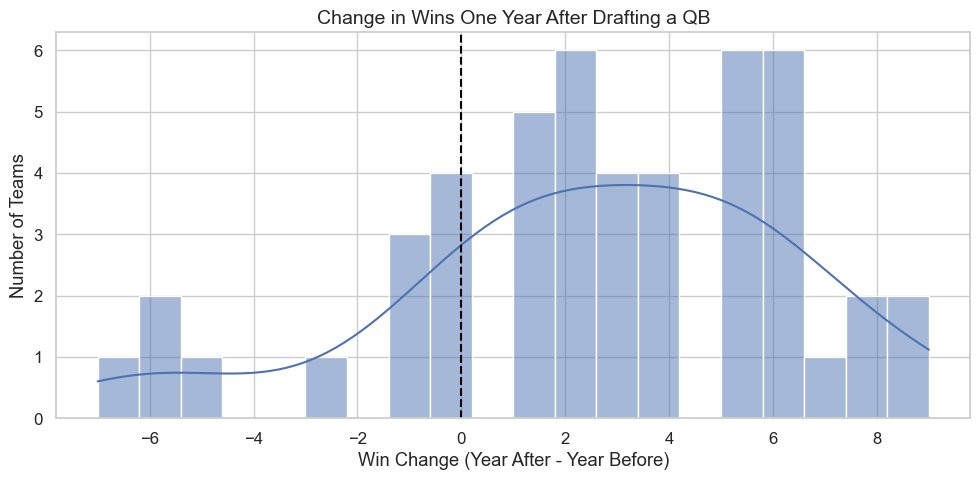

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# visual style
sns.set_theme(style="whitegrid", font_scale=1.1, palette="deep")
plt.rcParams["figure.figsize"] = (10, 6)

# Calculate deltas
qb_drafts_cleaned["change_after_1"] = qb_drafts_cleaned["wins_after_1"] - qb_drafts_cleaned["wins_before"]
qb_drafts_cleaned["change_after_5"] = qb_drafts_cleaned["wins_after_5"] - qb_drafts_cleaned["wins_before"]
qb_drafts_cleaned["change_from_3yr_avg"] = qb_drafts_cleaned["wins_after_1"] - qb_drafts_cleaned["wins_before_3yr_avg"]

# Distribution of Year-1 Change in Wins
plt.figure(figsize=(10, 5))
sns.histplot(qb_drafts_cleaned["change_after_1"], kde=True, bins=20)
plt.axvline(0, color="black", linestyle="--", lw=1.5)
plt.title("Change in Wins One Year After Drafting a QB", fontsize=14)
plt.xlabel("Win Change (Year After - Year Before)")
plt.ylabel("Number of Teams")
plt.tight_layout()
plt.show()

This histogram shows how much teams improved (or declined) in wins one year after drafting a quarterback.
- Most teams saw improvement (centered right of 0)
- A few had major jumps or drops, potentially due to other factors like coaching/defense/etc. but most trended positive

#### T-Test: Are Top-10 QB Picks Significantly Better?

Before visualizing the 1-year win change by draft tier, I wanted to check if the difference between top-10 and non-top-10 QB picks is statistically significant.

To do this, I ran a **two-sample independent t-test** comparing the average Year-1 win change for teams that drafted QBs in the top 10 vs. those who drafted later in the first round.


In [ ]:
from scipy.stats import ttest_ind

# Separate Year-1 win changes by pick type
top10 = qb_drafts_cleaned[qb_drafts_cleaned["top_10"] == True]["change_after_1"].dropna()
not_top10 = qb_drafts_cleaned[qb_drafts_cleaned["top_10"] == False]["change_after_1"].dropna()

# Run t-test
t_stat, p_val = ttest_ind(top10, not_top10, equal_var=False)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("There is a statistically significant difference between the two groups.")
else:
    print("No significant difference detected between top-10 and later QB picks.")


T-statistic: 3.586
P-value: 0.0009
✅ There is a statistically significant difference between the two groups.


The p-value was **0.0009**, well below the 0.05 threshold, so the result is **statistically significant**. Woo!

### 4b. Top-10 QBs vs Others: 1-Year Win Change

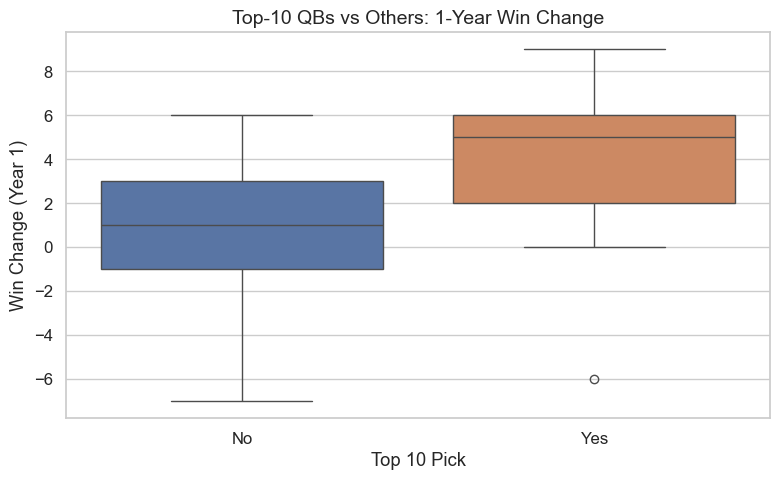

In [15]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=qb_drafts_cleaned, x="top_10", y="change_after_1", hue="top_10", legend=False)
plt.title("Top-10 QBs vs Others: 1-Year Win Change", fontsize=14)
plt.xlabel("Top 10 Pick")
plt.ylabel("Win Change (Year 1)")
plt.xticks([0, 1], ["No", "Yes"])
plt.tight_layout()
plt.show()

This boxplot compares win changes between teams that drafted a QB in the top 10 versus later in the round.
- Top-10 picks show a noticeably higher median win improvement suggesting that high-value picks often pay off in the short term.

### 4c. Do Struggling Teams Improve After Drafting a QB?

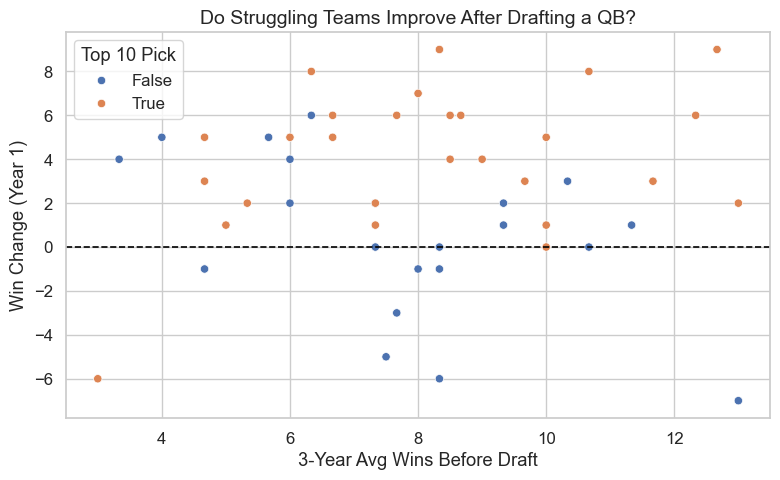

In [16]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=qb_drafts_cleaned,
    x="wins_before_3yr_avg", y="change_after_1", hue="top_10"
)
plt.axhline(0, color="black", linestyle="--", lw=1.2)
plt.title("Do Struggling Teams Improve After Drafting a QB?", fontsize=14)
plt.xlabel("3-Year Avg Wins Before Draft")
plt.ylabel("Win Change (Year 1)")
plt.legend(title="Top 10 Pick")
plt.tight_layout()
plt.show()

This scatterplot shows each draft pick based on their team's 3-year win average before the draft and the team's win change in the season after selecting the QB. 
- Teams with lower average wins (on the left) tend to show more variability but many did improve, especially with top-10 picks.

### 4d. Long-Term Team Impact

If early picks really help turn a franchise around, we would expect to see positive win changes persist or grow over time. This should be even more prominent for top-10 selections.

In the next two charts I explore 5-year win changes and longer-term trends by pick position.

### 4e. Change in Wins Five Years After Drafting a QB

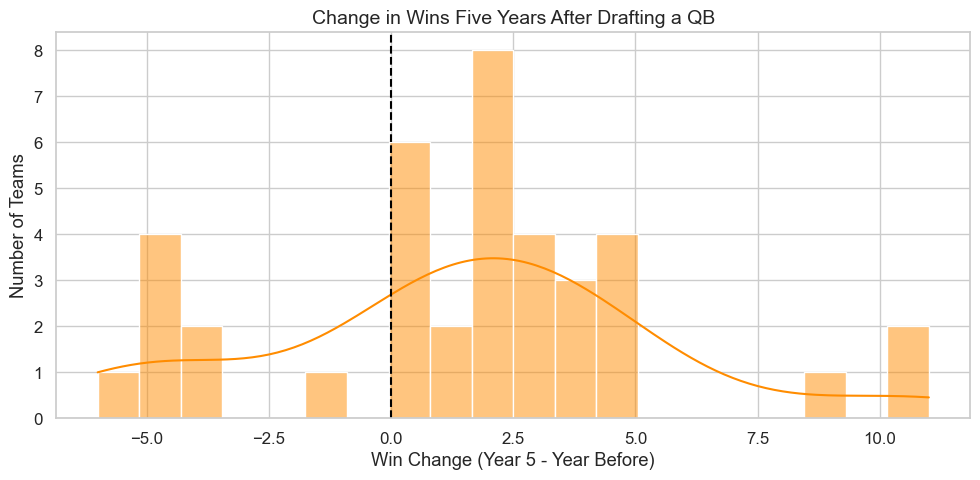

In [17]:
plt.figure(figsize=(10, 5))
sns.histplot(qb_drafts_cleaned["change_after_5"], kde=True, bins=20, color="darkorange")
plt.axvline(0, color="black", linestyle="--", lw=1.5)
plt.title("Change in Wins Five Years After Drafting a QB", fontsize=14)
plt.xlabel("Win Change (Year 5 - Year Before)")
plt.ylabel("Number of Teams")
plt.tight_layout()
plt.show()

This histogram illustrates how teams’ win totals changed five years after selecting a quarterback, compared to the year before the draft.
- While results are more spread out than year-one changes (resembling a normal distibution centered at ~2), the center still trends positive.
- Overall, teams either see sustained success or boom/bust effects.

### 4f. Win Change Over Time by Draft Pick Type

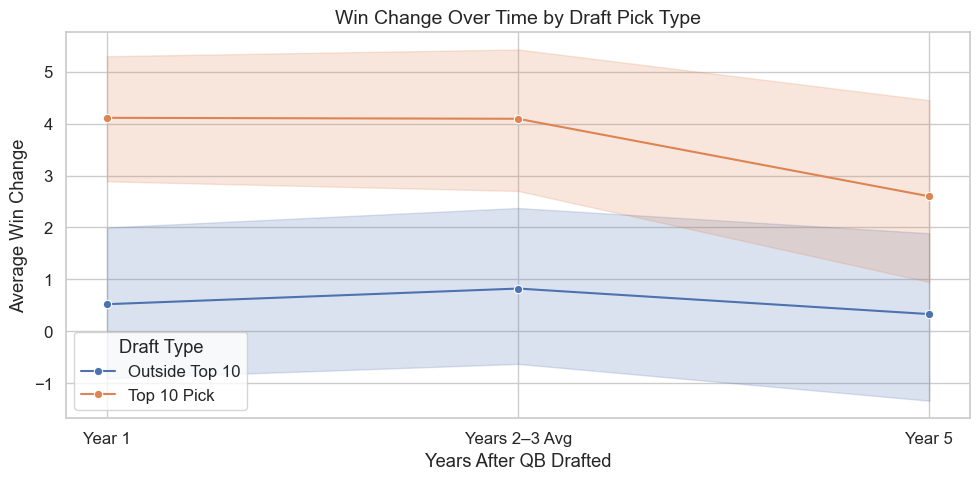

In [18]:
# Prepare data
avg_trend = qb_drafts_cleaned.copy()
avg_trend["change_2_3"] = avg_trend["wins_after_2_3"] - avg_trend["wins_before"]
avg_trend_long = avg_trend.melt(
    id_vars=["top_10"],
    value_vars=["change_after_1", "change_2_3", "change_after_5"],
    var_name="period",
    value_name="win_change"
)

# Map period names
avg_trend_long["period"] = avg_trend_long["period"].map({
    "change_after_1": "Year 1",
    "change_2_3": "Years 2–3 Avg",
    "change_after_5": "Year 5"
})

# Map label for hue
avg_trend_long["Draft Type"] = avg_trend_long["top_10"].map({True: "Top 10 Pick", False: "Outside Top 10"})

# Plot with hue and legend
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=avg_trend_long,
    x="period",
    y="win_change",
    hue="Draft Type",     # readable legend
    marker="o"
)

plt.title("Win Change Over Time by Draft Pick Type", fontsize=14)
plt.xlabel("Years After QB Drafted")
plt.ylabel("Average Win Change")
plt.legend(title="Draft Type")
plt.tight_layout()
plt.show()

This line plot charts average win change at our three established benchmarks: Year 1, Years 2–3 average, and Year 5.

I separated results by draft pick range to visually compare our two groups of QBs. The shaded areas show confidence intervals, which are how much the win change results vary between teams. (Wider areas mean outcomes were more spread out).

- Top-10 QBs are generally associated with higher average win gains across all timeframes.
- These gains peak around Year 2–3 then taper by Year 5, though still ending positive on average.
- Outside top-10 picks show smaller average changes and less variation.

## 5. Results & Conclusions

After analyzing team win changes following the selection of a first-round quarterback, several key insights emerged alongside important caveats.

### Key Takeaways for Stakeholders
- **Top-10 QBs can deliver meaningful team improvement** particularly by Years 2–3, but their outcomes are more volatile. Teams should pair these picks with long-term planning and support systems.
- **Struggling teams stand to benefit the most** but usually when a QB is part of a broader rebuild. Drafting alone won’t fix foundational issues.
- **Drafting a QB is a high-variance move.** It carries extreme risk for some orgs, but can reshape a team’s trajectory and quickly reestablish a winning culture.

#### Year-1 Win Bumps Are Common But Inconsistent
> Teams tend to see a modest boost in win totals the season after drafting a first-round QB.     

As seen in the year-one histogram (4a), the distribution of year-one changes skews positive with some variation. Many teams gained 6–8 wins or more while others only mustered 1-2 or declined. A new QB can be part of a turnaround but is not a quick fix for larger holes.

#### Top-10 Picks Drive Bigger (But Riskier) Results
> QBs selected within the top 10 consistently outperformed their later first-round counterparts across all timeframes.   

As shown in the 1-year boxplot (4b) and long-term line plot (4f), their teams showed larger average gains by Year 2–3 and remained ahead even five years later. However, these picks also showed greater variability, suggesting top-10 selections offer higher upside with higher risk. Overall, teams spending premium draft capital on talented prospects generally see a positive return.

#### Struggling Teams Do See Upside
> Teams with lower win totals before drafting a QB were very likely to improve, though not always.         

In the scatterplot (4c), many of the biggest post-draft improvements came from franchises that were previously underperforming. Still, outcomes were more spread out for these teams. Poor foundations can make it harder for new QBs to succeed, even when highly drafted; in fact, successful organizations saw more consistent improvement after drafting QBs earlier.

#### Long-Term Trends Lean Slightly Positive
> When tracking outcomes five years out, the most consistent improvements occur in years 2–3 and tend to hold or taper by Year 5.

In the line plot (4f), some teams declined but long-term impact was modestly positive. QB picks often lead to longer-term gains when supported appropriately. However, is not uncommon for a 2nd- or 3rd-year QB to be thrown into a new coaching system and front office. These organizational shifts and lack of support after Years 2-3 have tangible effects on team success.

**Reminder:** There are some notable exclusions, found within my `excluded_qbs.csv`, which complicate the analysis. Important outliers include Aaron Rodgers, Michael Vick, and JaMarcus Russell among others. These players had measurable effects on their franchises' success but were not considered at this time.

## Attribution
This project uses public data via [`nfl_data_py`](https://github.com/nflverse/nfl_data_py).

Thank you to the developers and data maintainers of this amazing package and its associated libraries:
- [Alec Ostrander](https://twitter.com/AlecOstrander)
- [Ben Baldwin](https://twitter.com/benbbaldwin)
- [Sebastian Carl](https://twitter.com/mrcaseb)
- [Lee Sharpe](https://twitter.com/LeeSharpeNFL)
- [Tan Ho](https://twitter.com/_TanH)
- Josh Kazan